In [5]:
from pathlib import Path
from scipy.io import loadmat

# Path to dataset root containing interictal, preictal, ictal folders
DATA_ROOT = Path("../DATASET-3") 

# Initialize dictionary for categorized EEG states
dataset = { "interictal": [], "preictal": [], "ictal": [] }

for label in dataset:
    folder = DATA_ROOT / label  # ../datasets/interictal, preictal, ictal
    mat_files = sorted(folder.glob(f"{label}*.mat"))  # e.g., interictal*.mat

    if not mat_files:
        print(f"⚠️  No .mat files found in {folder}")
        continue

    print(f"📂 Reading {len(mat_files)} files from “{label}”…")
    for f in mat_files:
        try:
            data = loadmat(f)  # Load MATLAB .mat file
            dataset[label].append({"file": f.name, "data": data})
        except Exception as e:
            print(f"  ⛔️ Error reading {f.name}: {e}")

print("\n✔️  Reading completed.")

📂 Reading 50 files from “interictal”…
📂 Reading 50 files from “preictal”…
📂 Reading 50 files from “ictal”…

✔️  Reading completed.


In [6]:
# Extract the first .mat file from each category, if available
sample_interictal = dataset["interictal"][0]["data"] if dataset["interictal"] else None
sample_preictal   = dataset["preictal"][0]["data"]   if dataset["preictal"]   else None
sample_ictal      = dataset["ictal"][0]["data"]      if dataset["ictal"]      else None

# Store samples in a dictionary for easier iteration
sample_data = {
    "interictal": sample_interictal,
    "preictal":   sample_preictal,
    "ictal":      sample_ictal,
}

# Print the top-level keys of each .mat file to inspect its structure
for label, mat in sample_data.items():
    if mat is None:
        print(f"{label}: folder is empty")
    else:
        print(f"{label}: keys → {list(mat.keys())}")

interictal: keys → ['__header__', '__version__', '__globals__', 'interictal']
preictal: keys → ['__header__', '__version__', '__globals__', 'preictal']
ictal: keys → ['__header__', '__version__', '__globals__', 'ictal']


In [7]:
import numpy as np
from collections import Counter

def signal_length(mat_dict, label):
    """Returns the length (number of samples) of the signal."""
    return np.asarray(mat_dict[label]).squeeze().shape[-1]

lengths_summary = {}

for label, files in dataset.items():
    if not files:
        print(f"{label}: folder is empty")
        continue

    # Get the length of each signal in the class
    lengths = [signal_length(d["data"], label) for d in files]
    lengths_summary[label] = Counter(lengths)

    unique = list(lengths_summary[label].items())
    if len(unique) == 1:
        length, count = unique[0]
        print(f"{label}: all signals have {length} samples (n={count}) ✅")
    else:
        print(f"{label}: varying lengths → {unique} ⚠️")

interictal: all signals have 1024 samples (n=50) ✅
preictal: all signals have 1024 samples (n=50) ✅
ictal: all signals have 1024 samples (n=50) ✅


In [4]:
import numpy as np

def get_signal_arr(mat_dict, label):
    """
    Extracts the mono-channel signal from a .mat dictionary,
    using the key matching the folder name.
    """
    return np.asarray(mat_dict[label]).squeeze()

# Stack all signals into arrays per class
interictal_arr = np.stack(
    [get_signal_arr(d["data"], "interictal") for d in dataset["interictal"]],
    axis=0
)
preictal_arr = np.stack(
    [get_signal_arr(d["data"], "preictal") for d in dataset["preictal"]],
    axis=0
)
ictal_arr = np.stack(
    [get_signal_arr(d["data"], "ictal") for d in dataset["ictal"]],
    axis=0
)

# Display the resulting shapes
print("interictal_arr.shape =", interictal_arr.shape)
print("preictal_arr.shape  =", preictal_arr.shape)
print("ictal_arr.shape     =", ictal_arr.shape)


interictal_arr.shape = (50, 1024)
preictal_arr.shape  = (50, 1024)
ictal_arr.shape     = (50, 1024)


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 1) Unir todas las señales en una sola matriz (150, 1024) ---
all_signals = np.vstack([interictal_arr, preictal_arr, ictal_arr])
print("✅ all_signals.shape =", all_signals.shape)

# --- 2) Crear vector de etiquetas ---
# 0 = interictal (50 señales), 1 = preictal (50), 2 = ictal (50)
labels = np.array([0]*interictal_arr.shape[0] +
                  [1]*preictal_arr.shape[0] +
                  [2]*ictal_arr.shape[0])
print("✅ labels.shape =", labels.shape)

# --- 3) Normalizar los datos (media 0, varianza 1) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_signals)

# --- 4) Aplicar PCA con 100 componentes ---
n_components = 100
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
print("✅ X_pca.shape =", X_pca.shape)

# --- 5) Crear un DataFrame con los 100 componentes + etiqueta ---
pca_df = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
pca_df["Label"] = labels

# --- 6) Varianza explicada acumulada ---
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"✅ Varianza explicada acumulada con {n_components} componentes: {explained_variance*100:.2f}%")

# --- 7) Guardar en CSV ---
csv_filename = "EEG_PCA_100features.csv"
pca_df.to_csv(csv_filename, index=False)
print(f"✅ Archivo guardado como: {csv_filename}")

# --- 8) Vista previa ---
pca_df.head()

✅ all_signals.shape = (150, 1024)
✅ labels.shape = (150,)
✅ X_pca.shape = (150, 100)
✅ Varianza explicada acumulada con 100 componentes: 99.74%
✅ Archivo guardado como: EEG_PCA_100features.csv


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,Label
0,0.360065,-2.755852,-1.252155,0.165785,0.004042,0.978866,-1.795153,-0.254739,-1.410987,-0.813458,...,0.193851,1.088559,0.052204,0.643180,-0.201055,0.249108,-0.814195,-0.761765,-0.221651,0
1,0.699413,-1.181798,-0.596559,-0.976129,-1.387017,1.682146,-0.619740,0.597749,-0.003137,-0.412038,...,-0.184741,-0.006948,0.106617,0.180846,-0.758948,0.296521,-0.274573,0.909833,0.189730,0
2,1.312441,-1.440537,0.075986,0.058628,0.098679,1.083433,0.678750,0.190877,0.603506,-0.633814,...,0.124323,-0.458050,0.645102,-0.707988,-0.674562,-0.304645,0.719247,-0.549028,-0.294336,0
3,1.051674,-2.093073,-0.033584,-0.022670,-1.055177,0.213385,-0.665087,-0.207276,-0.549646,-0.323383,...,0.328226,-0.166302,-0.035922,0.442002,-0.394080,0.642850,0.007052,-0.488097,0.659748,0
4,-0.261451,-1.801624,0.601794,0.853112,-0.973168,1.208302,-0.822903,-1.251470,-0.128257,-0.032636,...,0.483857,-0.559760,-1.017291,-0.552792,-0.095359,0.143129,0.848203,-0.750854,-0.205262,0


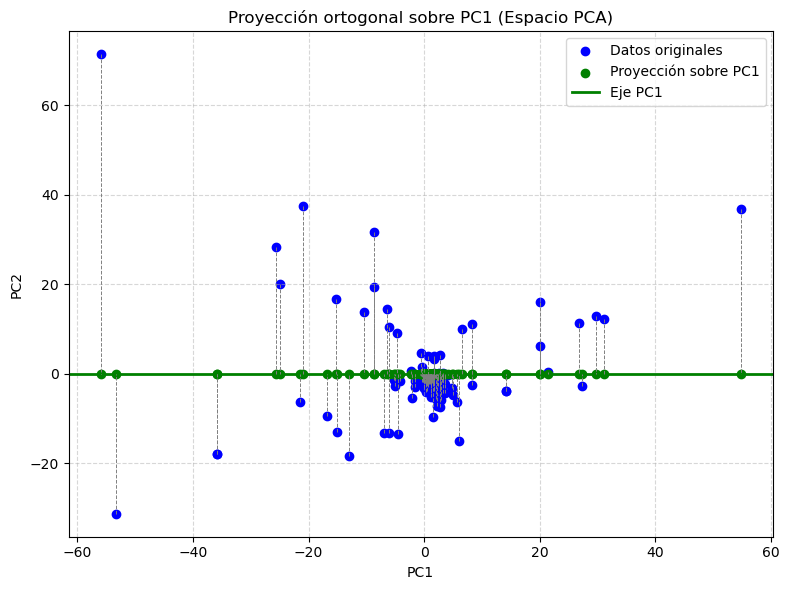

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Extraer PC1 y PC2 ---
pc1 = pca_df["PC1"].values
pc2 = pca_df["PC2"].values

# --- 2) Calcular proyección ortogonal sobre PC1 ---
# La proyección en el espacio PCA es simplemente (PC1, 0) porque estamos "aplanando" en PC1
proj_pc1 = np.zeros_like(pc2)

# --- 3) Graficar ---
plt.figure(figsize=(8,6))
plt.title("Proyección ortogonal sobre PC1 (Espacio PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Datos originales
plt.scatter(pc1, pc2, color="blue", label="Datos originales")

# Proyección sobre PC1
plt.scatter(pc1, proj_pc1, color="green", label="Proyección sobre PC1")

# Eje PC1
plt.axhline(0, color="green", linewidth=2, label="Eje PC1")

# Líneas de proyección
for x, y in zip(pc1, pc2):
    plt.plot([x, x], [y, 0], "gray", linestyle="--", linewidth=0.7)

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


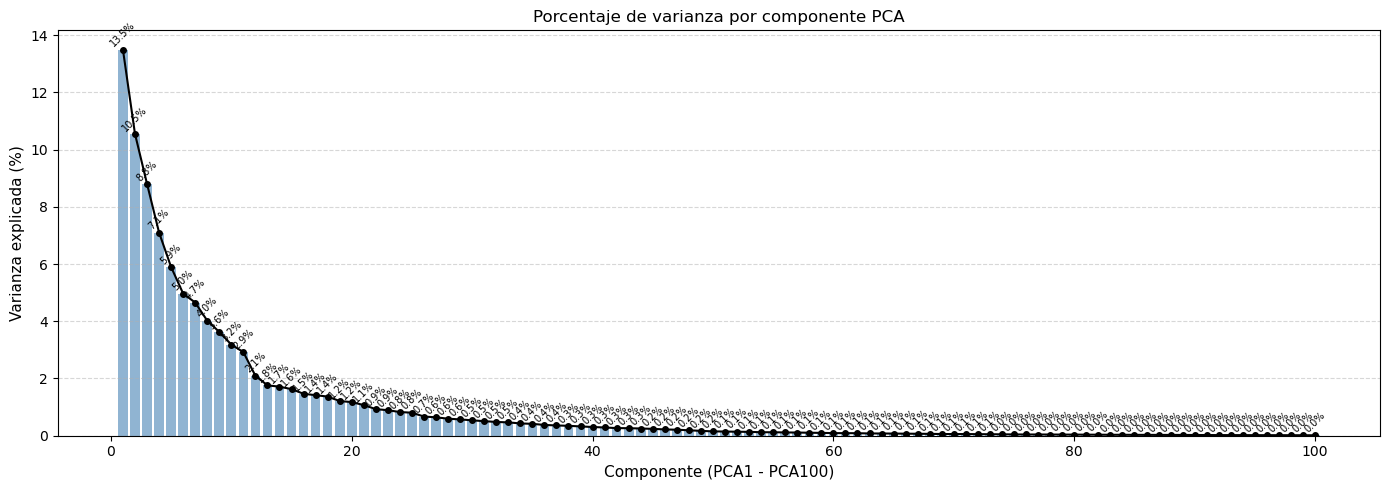

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Obtener la varianza explicada del PCA ya calculado ---
explained_var = pca.explained_variance_ratio_ * 100  # en porcentaje

# --- 2) Crear la gráfica ---
plt.figure(figsize=(14, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.6, color="steelblue", label="Varianza explicada")
plt.plot(range(1, len(explained_var) + 1), explained_var, 'ko-', markersize=4)

# --- 3) Anotar los porcentajes encima de cada barra ---
for i, v in enumerate(explained_var):
    plt.text(i + 1, v + 0.1, f"{v:.1f}%", ha='center', fontsize=7, rotation=45)

# --- 4) Ajustes de la gráfica ---
plt.title("Porcentaje de varianza por componente PCA", fontsize=12)
plt.xlabel("Componente (PCA1 - PCA100)", fontsize=11)
plt.ylabel("Varianza explicada (%)", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
